# Método de Transformación

In [51]:
import pandas as pd
import numpy as np
import sidetable
import pymongo

import folium
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append("../")
import src.creacion_columnas as cc

### Importamos CSV

Nos descarmos el CSV que hemos creado, enriqueciendo el CSV inicial con Selenium:

In [3]:
df3 = pd.read_csv ("../Data/02.1 Datos_mergeados_limpieza_inical.csv")
df3.head(2)

,Unnamed: 0,Price,Currency,Brokered_by,AD_Situation,Rooms,Bath,Building space,Measruing unit,Address,...,State,Índice_poder_adqui,Índice_seguridad,Índice_sanidad,Índice_clima,Índice_costo_vida,Relación_precio_ingresos_propiedades,Índice_costo_desplazamiento,Índice_contaminación,Índice_calidad_vida
0,0,289900,USD,Greene Realty Group LLC,New - 7 hours ago,3,2.0,1944,sqft,"5142 Puget Rd NE, Olympia, WA 98516",...,WA 98516,"108,43","70,61","71,99","83,44","70,23","3,37","19,11","16,01","204,67"
1,1,146999,USD,Adair Homes,Old,3,2.0,1340,sqft,"South Puget Sound 2303 93rd Ave SW, Olympia, W...",...,WA 98512,"108,43","70,61","71,99","83,44","70,23","3,37","19,11","16,01","204,67"


### Manipulación de columnas

Vamos a reescribir la columna "AD_Situation" para que únicamente muestre dos opciones: New, old. 

Vamos a reescribir la columna "State" para que únicamente muestra la primera parte de los string, es decir: WA, OR o CA.

Para ello, hemos creado una función "quitar_horas" donde haremos un split por espacio y nos quedaremos con la primera parte del string!

In [4]:
df3["AD_Situation"] = df3["AD_Situation"].apply(cc.quitar_horas)
df3["State"] = df3["State"].apply(cc.quitar_horas)
df3.head(1)

,Unnamed: 0,Price,Currency,Brokered_by,AD_Situation,Rooms,Bath,Building space,Measruing unit,Address,...,State,Índice_poder_adqui,Índice_seguridad,Índice_sanidad,Índice_clima,Índice_costo_vida,Relación_precio_ingresos_propiedades,Índice_costo_desplazamiento,Índice_contaminación,Índice_calidad_vida
0,0,289900,USD,Greene Realty Group LLC,New,3,2.0,1944,sqft,"5142 Puget Rd NE, Olympia, WA 98516",...,WA,"108,43","70,61","71,99","83,44","70,23","3,37","19,11","16,01","204,67"


De nuevo vamos a reescriir la columna "State", pero para que este vez muestre los 3 Estados en su nomnbre completo: California, Oregón, Washington: 

Para ello hemos creado la función "cambiar"!

In [5]:
df3["State"] = df3.apply(lambda datos: cc.cambiar(datos["State"]),axis = 1)

Vamos a crear una nueva columna "Measuring unit" y vamos a indicar como unidad de medida "m2".

Vamos a reescribir la columna "Bulding space" para que la información se muestra en m2 en vez de sqft. Para ello lo vamos a dividir por 10.764.

Vamos a crear una columna nueva "Price/m2", donde vamos dividir la columna "Price" por la columna "Building space". 

In [6]:
df3['Measuring unit']= df3['Measruing unit'].replace("sqft","m2")
df3['Building space']= round(df3['Building space']/10.764, 0)
df3['Price/m2']= round((df3['Price'])/(df3['Building space']), 0)
df3.head(1)

,Unnamed: 0,Price,Currency,Brokered_by,AD_Situation,Rooms,Bath,Building space,Measruing unit,Address,...,Índice_seguridad,Índice_sanidad,Índice_clima,Índice_costo_vida,Relación_precio_ingresos_propiedades,Índice_costo_desplazamiento,Índice_contaminación,Índice_calidad_vida,Measuring unit,Price/m2
0,0,289900,USD,Greene Realty Group LLC,New,3,2.0,181.0,sqft,"5142 Puget Rd NE, Olympia, WA 98516",...,"70,61","71,99","83,44","70,23","3,37","19,11","16,01","204,67",m2,1602.0


Vamos a crear tres columnas nuevas, "Direction", "Ciudad1", "Postal_code" a partir de la columna "Address", donde vamos a hacer un split por ",", y nos vamos a quedar con las 3 primeras palabras del string:

In [7]:
df3[["Direction", "Ciudad1", "Postal_code"]]  = df3["Address"].str.split(",",  expand=True).iloc[:, :3]

Vamos a reescribir la columna "Direction" para que nos de la dirección y la ciudad en la misma columna. Para ello, vamos a sumar los strings de las columnas "Direction" y "Ciudad1":

In [8]:
df3["Direction"] = df3["Direction"] + "," + df3["Ciudad1"]
df3.head(1)

,Unnamed: 0,Price,Currency,Brokered_by,AD_Situation,Rooms,Bath,Building space,Measruing unit,Address,...,Índice_costo_vida,Relación_precio_ingresos_propiedades,Índice_costo_desplazamiento,Índice_contaminación,Índice_calidad_vida,Measuring unit,Price/m2,Direction,Ciudad1,Postal_code
0,0,289900,USD,Greene Realty Group LLC,New,3,2.0,181.0,sqft,"5142 Puget Rd NE, Olympia, WA 98516",...,"70,23","3,37","19,11","16,01","204,67",m2,1602.0,"5142 Puget Rd NE, Olympia",Olympia,WA 98516


Vamos a reescribir la columna "Postal_code" para que nos de únicamente el código postal: 

Para ello, utilizando regex, vamos a quedarnos únicamente con los valores numéricos del string

In [9]:
df3["Postal_code"] = df3.Postal_code.str.extract("(\d+)", expand=True)
df3.head(1)

,Unnamed: 0,Price,Currency,Brokered_by,AD_Situation,Rooms,Bath,Building space,Measruing unit,Address,...,Índice_costo_vida,Relación_precio_ingresos_propiedades,Índice_costo_desplazamiento,Índice_contaminación,Índice_calidad_vida,Measuring unit,Price/m2,Direction,Ciudad1,Postal_code
0,0,289900,USD,Greene Realty Group LLC,New,3,2.0,181.0,sqft,"5142 Puget Rd NE, Olympia, WA 98516",...,"70,23","3,37","19,11","16,01","204,67",m2,1602.0,"5142 Puget Rd NE, Olympia",Olympia,98516


Vamos a eliminar las columna que no nos interesan por estar la información "duplicada"

In [10]:
eliminar_columns = ['Address', 'Unnamed: 0', 'Ciudad1', 'Measruing unit']


In [11]:
df3_limpio = df3.drop(eliminar_columns, axis = 1)
df3_limpio.head(1)

,Price,Currency,Brokered_by,AD_Situation,Rooms,Bath,Building space,City,State,Índice_poder_adqui,...,Índice_clima,Índice_costo_vida,Relación_precio_ingresos_propiedades,Índice_costo_desplazamiento,Índice_contaminación,Índice_calidad_vida,Measuring unit,Price/m2,Direction,Postal_code
0,289900,USD,Greene Realty Group LLC,New,3,2.0,181.0,Olympia,Washington,"108,43",...,"83,44","70,23","3,37","19,11","16,01","204,67",m2,1602.0,"5142 Puget Rd NE, Olympia",98516


### Estandarización del tipado de las columnas

Vamos a ordenar las columnas de nuestro DataFrame para que tenga algo más de sentido:

In [12]:
df3_limpio = df3_limpio.reindex(columns=['Price', 'Currency', 'AD_Situation', 'Rooms', 'Bath', 'Building space', 'Measuring unit', 'Price/m2', 'Brokered_by', 'Direction', 'City', 'State', 'Postal_code',
       'Índice_poder_adqui', 'Índice_seguridad', 'Índice_sanidad',
       'Índice_clima', 'Índice_costo_vida',
       'Relación_precio_ingresos_propiedades', 'Índice_costo_desplazamiento',
       'Índice_contaminación', 'Índice_calidad_vida'])
df3_limpio.head(1)

,Price,Currency,AD_Situation,Rooms,Bath,Building space,Measuring unit,Price/m2,Brokered_by,Direction,...,Postal_code,Índice_poder_adqui,Índice_seguridad,Índice_sanidad,Índice_clima,Índice_costo_vida,Relación_precio_ingresos_propiedades,Índice_costo_desplazamiento,Índice_contaminación,Índice_calidad_vida
0,289900,USD,New,3,2.0,181.0,m2,1602.0,Greene Realty Group LLC,"5142 Puget Rd NE, Olympia",...,98516,"108,43","70,61","71,99","83,44","70,23","3,37","19,11","16,01","204,67"


A continuación, vamos a homogeneizar las columnas: pasar los nombres de las columnas a minusculas y reemplazar los espacios por "_":

In [13]:
diccionario = {}
for col in df3_limpio.columns:
    diccionario[col] = col.lower().strip().replace(" ", "_")

In [14]:
nuevas_columnas = {col : col.lower().strip().replace(" ", "_") for col in df3_limpio.columns}
nuevas_columnas

{'Price': 'price',
 'Currency': 'currency',
 'AD_Situation': 'ad_situation',
 'Rooms': 'rooms',
 'Bath': 'bath',
 'Building space': 'building_space',
 'Measuring unit': 'measuring_unit',
 'Price/m2': 'price/m2',
 'Brokered_by': 'brokered_by',
 'Direction': 'direction',
 'City': 'city',
 'State': 'state',
 'Postal_code': 'postal_code',
 'Índice_poder_adqui': 'índice_poder_adqui',
 'Índice_seguridad': 'índice_seguridad',
 'Índice_sanidad': 'índice_sanidad',
 'Índice_clima': 'índice_clima',
 'Índice_costo_vida': 'índice_costo_vida',
 'Relación_precio_ingresos_propiedades': 'relación_precio_ingresos_propiedades',
 'Índice_costo_desplazamiento': 'índice_costo_desplazamiento',
 'Índice_contaminación': 'índice_contaminación',
 'Índice_calidad_vida': 'índice_calidad_vida'}

In [15]:
df3_limpio.rename(columns = nuevas_columnas, inplace =True)
df3_limpio.head(1)

,price,currency,ad_situation,rooms,bath,building_space,measuring_unit,price/m2,brokered_by,direction,...,postal_code,índice_poder_adqui,índice_seguridad,índice_sanidad,índice_clima,índice_costo_vida,relación_precio_ingresos_propiedades,índice_costo_desplazamiento,índice_contaminación,índice_calidad_vida
0,289900,USD,New,3,2.0,181.0,m2,1602.0,Greene Realty Group LLC,"5142 Puget Rd NE, Olympia",...,98516,"108,43","70,61","71,99","83,44","70,23","3,37","19,11","16,01","204,67"


### Tipo de Datos

Problema: La columna "baños" está en formato "float". Debemos convertirlas a integer. Las columans "índice_poder_adqui', 'índice_seguridad', 'índice_sanidad', 'índice_clima', 'índice_costo_vida', 'relación_precio_ingresos_propiedades', 'índice_costo_desplazamiento', 'índice_contaminación', 'índice_calidad_vida' están en formato "string"... Tendremos que hacer algo con ellas más adelante. Debemos convertirlas a integer:

In [16]:
df3_limpio.dtypes

price                                     int64
currency                                 object
ad_situation                             object
rooms                                     int64
bath                                    float64
building_space                          float64
measuring_unit                           object
price/m2                                float64
brokered_by                              object
direction                                object
city                                     object
state                                    object
postal_code                              object
índice_poder_adqui                       object
índice_seguridad                         object
índice_sanidad                           object
índice_clima                             object
índice_costo_vida                        object
relación_precio_ingresos_propiedades     object
índice_costo_desplazamiento              object
índice_contaminación                    

In [17]:
df3_limpio["bath"] = df3_limpio["bath"].astype(int)
df3_limpio.head(2)

,price,currency,ad_situation,rooms,bath,building_space,measuring_unit,price/m2,brokered_by,direction,...,postal_code,índice_poder_adqui,índice_seguridad,índice_sanidad,índice_clima,índice_costo_vida,relación_precio_ingresos_propiedades,índice_costo_desplazamiento,índice_contaminación,índice_calidad_vida
0,289900,USD,New,3,2,181.0,m2,1602.0,Greene Realty Group LLC,"5142 Puget Rd NE, Olympia",...,98516,"108,43","70,61","71,99","83,44","70,23","3,37","19,11","16,01","204,67"
1,146999,USD,Old,3,2,124.0,m2,1185.0,Adair Homes,"South Puget Sound 2303 93rd Ave SW, Olympia",...,98512,"108,43","70,61","71,99","83,44","70,23","3,37","19,11","16,01","204,67"


In [18]:
z = ['índice_poder_adqui', 'índice_seguridad',
       'índice_sanidad', 'índice_clima', 'índice_costo_vida',
       'relación_precio_ingresos_propiedades', 'índice_costo_desplazamiento',
       'índice_contaminación', 'índice_calidad_vida']

In [19]:
df3_limpio = df3_limpio.apply(lambda datos: cc.puntos2(datos, z), axis = 1)

In [20]:
df3_limpio.head(1)

,price,currency,ad_situation,rooms,bath,building_space,measuring_unit,price/m2,brokered_by,direction,...,postal_code,índice_poder_adqui,índice_seguridad,índice_sanidad,índice_clima,índice_costo_vida,relación_precio_ingresos_propiedades,índice_costo_desplazamiento,índice_contaminación,índice_calidad_vida
0,289900,USD,New,3,2,181.0,m2,1602.0,Greene Realty Group LLC,"5142 Puget Rd NE, Olympia",...,98516,108.43,70.61,71.99,83.44,70.23,3.37,19.11,16.01,204.67


In [21]:
df3_limpio.dtypes

price                                     int64
currency                                 object
ad_situation                             object
rooms                                     int64
bath                                      int64
building_space                          float64
measuring_unit                           object
price/m2                                float64
brokered_by                              object
direction                                object
city                                     object
state                                    object
postal_code                              object
índice_poder_adqui                      float64
índice_seguridad                        float64
índice_sanidad                          float64
índice_clima                            float64
índice_costo_vida                       float64
relación_precio_ingresos_propiedades    float64
índice_costo_desplazamiento             float64
índice_contaminación                    

### Duplicados

Problema: Duplicado. En el análisis exploratorio identificamos 2 duplicados:

In [22]:
df3_limpio.duplicated().sum()

2

In [23]:
df3_limpio[df3_limpio.duplicated() == True]

,price,currency,ad_situation,rooms,bath,building_space,measuring_unit,price/m2,brokered_by,direction,...,postal_code,índice_poder_adqui,índice_seguridad,índice_sanidad,índice_clima,índice_costo_vida,relación_precio_ingresos_propiedades,índice_costo_desplazamiento,índice_contaminación,índice_calidad_vida
455,484000,USD,New,3,2,250.0,m2,1936.0,Pacific Lifestyle Homes,"Adam's Glen 16701 NE 88th St, Vancouver",...,98682,88.24,62.57,74.77,91.15,74.52,11.79,36.9,25.17,172.4
497,394000,USD,New,3,2,135.0,m2,2919.0,Pacific Lifestyle Homes,"Parkers Abby 11203 NE 133rd Pl., Vancouver",...,98682,88.24,62.57,74.77,91.15,74.52,11.79,36.9,25.17,172.4


Una vez identificamos las filas duplicadas, procedemos a su eliminación:

In [24]:
df3_limpio.drop_duplicates(inplace = True)

In [25]:
df3_limpio.duplicated().sum()

0

### Valores Nulos

In [26]:
df3_limpio.isnull().sum()

price                                   0
currency                                0
ad_situation                            0
rooms                                   0
bath                                    0
building_space                          0
measuring_unit                          0
price/m2                                0
brokered_by                             0
direction                               0
city                                    0
state                                   0
postal_code                             2
índice_poder_adqui                      0
índice_seguridad                        0
índice_sanidad                          0
índice_clima                            0
índice_costo_vida                       0
relación_precio_ingresos_propiedades    0
índice_costo_desplazamiento             0
índice_contaminación                    0
índice_calidad_vida                     0
dtype: int64

In [27]:
df3_limpio["postal_code"] = df3_limpio["postal_code"].fillna(0)

In [28]:
df3_limpio.isnull().sum()

price                                   0
currency                                0
ad_situation                            0
rooms                                   0
bath                                    0
building_space                          0
measuring_unit                          0
price/m2                                0
brokered_by                             0
direction                               0
city                                    0
state                                   0
postal_code                             0
índice_poder_adqui                      0
índice_seguridad                        0
índice_sanidad                          0
índice_clima                            0
índice_costo_vida                       0
relación_precio_ingresos_propiedades    0
índice_costo_desplazamiento             0
índice_contaminación                    0
índice_calidad_vida                     0
dtype: int64

In [29]:
df3_limpio["postal_code"].dtypes

dtype('O')

In [30]:
df3_limpio["postal_code"] = df3_limpio["postal_code"].astype(int)

In [31]:
df3_limpio["postal_code"].dtypes

dtype('int64')

### Principales estadísticos

Vamos a sacar los principales estadísticos a modo general, y también por estado, para ver qué insights podemos sacar

In [32]:
df3_limpio.describe().T

,count,mean,std,min,25%,50%,75%,max
price,677.0,594728.375185,425230.221514,27900.00,339500.00,450000.00,700000.00,3580000.00
rooms,677.0,3.209749,1.068799,1.00,3.00,3.00,4.00,8.00
bath,677.0,2.014771,0.873553,1.00,2.00,2.00,2.00,8.00
building_space,677.0,180.673560,79.423355,42.00,123.00,168.00,226.00,585.00
price/m2,677.0,3423.502216,1818.170878,297.00,2252.00,2917.00,4234.00,15049.00
postal_code,677.0,97471.968981,5528.146707,0.00,97236.00,98178.00,98506.00,98686.00
índice_poder_adqui,677.0,111.979158,24.924966,88.24,88.87,103.67,130.49,193.53
índice_seguridad,677.0,56.573471,11.606713,42.90,48.14,49.23,70.61,85.14
índice_sanidad,677.0,73.999365,2.095078,71.99,73.18,73.19,74.07,86.85
índice_clima,677.0,89.765229,3.546642,67.71,89.56,90.88,91.73,96.82


In [33]:
df3_limpio.describe(include = "object").T

,count,unique,top,freq
currency,677,1,USD,677
ad_situation,677,2,New,619
measuring_unit,677,1,m2,677
brokered_by,677,279,Adair Homes,29
direction,677,627,"South Puget Sound 2303 93rd Ave SW, Olympia",29
city,677,11,Portland,137
state,677,3,Washington,498


Nos sacamos los estadísticos por Estado para ver posibles insights

In [34]:
df3_limpio[df3_limpio["state"] == "California"].describe().T.round()

,count,mean,std,min,25%,50%,75%,max
price,42.0,1076962.0,760707.0,310000.0,612499.0,878395.0,1137250.0,3580000.0
rooms,42.0,4.0,1.0,1.0,3.0,4.0,4.0,8.0
bath,42.0,3.0,2.0,1.0,2.0,2.0,4.0,8.0
building_space,42.0,199.0,103.0,57.0,129.0,178.0,248.0,458.0
price/m2,42.0,5306.0,1763.0,3296.0,4120.0,4982.0,5892.0,12886.0
postal_code,42.0,92166.0,844.0,90803.0,91105.0,92616.0,92801.0,92807.0
índice_poder_adqui,42.0,114.0,15.0,96.0,96.0,108.0,130.0,130.0
índice_seguridad,42.0,61.0,17.0,43.0,47.0,47.0,79.0,80.0
índice_sanidad,42.0,77.0,3.0,74.0,74.0,78.0,79.0,87.0
índice_clima,42.0,95.0,6.0,68.0,95.0,96.0,97.0,97.0


In [35]:
df3_limpio[df3_limpio["state"] == "Oregón"].describe().T.round()

,count,mean,std,min,25%,50%,75%,max
price,137.0,565327.0,269319.0,199900.0,384900.0,495000.0,697500.0,1850000.0
rooms,137.0,3.0,1.0,1.0,3.0,3.0,4.0,8.0
bath,137.0,2.0,1.0,1.0,1.0,2.0,2.0,8.0
building_space,137.0,192.0,89.0,52.0,126.0,185.0,246.0,469.0
price/m2,137.0,3155.0,1175.0,1311.0,2363.0,2918.0,3563.0,8827.0
postal_code,137.0,97218.0,15.0,97201.0,97206.0,97217.0,97220.0,97266.0
índice_poder_adqui,137.0,104.0,0.0,104.0,104.0,104.0,104.0,104.0
índice_seguridad,137.0,48.0,0.0,48.0,48.0,48.0,48.0,48.0
índice_sanidad,137.0,73.0,0.0,73.0,73.0,73.0,73.0,73.0
índice_clima,137.0,90.0,0.0,90.0,90.0,90.0,90.0,90.0


In [36]:
df3_limpio[df3_limpio["state"] == "Washington"].describe().T.round()

,count,mean,std,min,25%,50%,75%,max
price,498.0,562147.0,396744.0,27900.0,325000.0,429950.0,686725.0,2800000.0
rooms,498.0,3.0,1.0,1.0,3.0,3.0,4.0,8.0
bath,498.0,2.0,1.0,1.0,2.0,2.0,2.0,4.0
building_space,498.0,176.0,74.0,42.0,121.0,165.0,220.0,585.0
price/m2,498.0,3339.0,1880.0,297.0,2165.0,2762.0,4222.0,15049.0
postal_code,498.0,97989.0,6232.0,0.0,98125.0,98422.0,98512.0,98686.0
índice_poder_adqui,498.0,114.0,28.0,88.0,89.0,108.0,146.0,194.0
índice_seguridad,498.0,59.0,12.0,46.0,49.0,63.0,71.0,85.0
índice_sanidad,498.0,74.0,2.0,72.0,73.0,74.0,75.0,81.0
índice_clima,498.0,89.0,3.0,83.0,91.0,91.0,92.0,92.0


In [37]:
df3_limpio[df3_limpio["state"] == "California"].describe().T["mean"].round()

price                                   1076962.0
rooms                                         4.0
bath                                          3.0
building_space                              199.0
price/m2                                   5306.0
postal_code                               92166.0
índice_poder_adqui                          114.0
índice_seguridad                             61.0
índice_sanidad                               77.0
índice_clima                                 95.0
índice_costo_vida                            75.0
relación_precio_ingresos_propiedades          6.0
índice_costo_desplazamiento                  32.0
índice_contaminación                         42.0
índice_calidad_vida                         181.0
Name: mean, dtype: float64

In [38]:
df3_limpio.columns

Index(['price', 'currency', 'ad_situation', 'rooms', 'bath', 'building_space',
       'measuring_unit', 'price/m2', 'brokered_by', 'direction', 'city',
       'state', 'postal_code', 'índice_poder_adqui', 'índice_seguridad',
       'índice_sanidad', 'índice_clima', 'índice_costo_vida',
       'relación_precio_ingresos_propiedades', 'índice_costo_desplazamiento',
       'índice_contaminación', 'índice_calidad_vida'],
      dtype='object')

In [39]:
df_pie = pd.DataFrame(df3_limpio.groupby(['city', 'state'])
                      ["price", "building_space", "price/m2", "índice_poder_adqui"].mean()).round().reset_index()

df_pie.head(12)

/var/folders/hb/9zbycmb97bx0n1b4ggqr8s_c0000gn/T/ipykernel_63447/1138327093.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_pie = pd.DataFrame(df3_limpio.groupby(['city', 'state'])


,city,state,price,building_space,price/m2,índice_poder_adqui
0,Anaheim,California,666788.0,170.0,4143.0,96.0
1,Bellevue,Washington,1118025.0,211.0,5280.0,194.0
2,Irvine,California,1390552.0,241.0,5632.0,130.0
3,Long Beach,California,867099.0,147.0,5820.0,108.0
4,Olympia,Washington,390706.0,189.0,2141.0,108.0
5,Pasadena,California,1765000.0,260.0,6772.0,106.0
6,Portland,Oregón,565327.0,192.0,3155.0,104.0
7,Redmond,Washington,1081514.0,225.0,4733.0,144.0
8,Seattle,Washington,840242.0,168.0,5285.0,146.0
9,Tacoma,Washington,399957.0,158.0,2694.0,89.0


### Preguntas que nos hacemos...

¿Guarda relación el precio de las vivienda con en tamaño de la vivienda?

¿Guarda relación los índices de contaminación y los de calidad de vida?

¿Los índices de seguridad, poder adquisitivo y sanidad, están relacionados?

¿Cuantos más cuartos en una casa, más baños?

¿Hay más contaminación cuanto mayor poder adquisitivo?

¿Hay relación entre el precio/m2 y el poder adquisitivo por ciudad?

### Geopy

In [40]:
from geopy.geocoders import Nominatim

In [41]:
locator = Nominatim(user_agent= "myGeocoder")

In [42]:
df3_limpio["latidud_"] = df3_limpio.apply(lambda datos: cc.latitud_v2(
                                    datos["postal_code"]), axis = 1)

In [43]:
df3_limpio["longitud_"] = df3_limpio.apply(lambda datos: cc.longitud_v2(
                                    datos["postal_code"]), axis = 1)

In [44]:
df3_limpio.head(2)

,price,currency,ad_situation,rooms,bath,building_space,measuring_unit,price/m2,brokered_by,direction,...,índice_seguridad,índice_sanidad,índice_clima,índice_costo_vida,relación_precio_ingresos_propiedades,índice_costo_desplazamiento,índice_contaminación,índice_calidad_vida,latidud_,longitud_
0,289900,USD,New,3,2,181.0,m2,1602.0,Greene Realty Group LLC,"5142 Puget Rd NE, Olympia",...,70.61,71.99,83.44,70.23,3.37,19.11,16.01,204.67,47.134266,-122.734934
1,146999,USD,Old,3,2,124.0,m2,1185.0,Adair Homes,"South Puget Sound 2303 93rd Ave SW, Olympia",...,70.61,71.99,83.44,70.23,3.37,19.11,16.01,204.67,47.011384,-122.926033


### Exportación de CSV limpio

Exportamos el DataFrame limpio a un CSV:

In [45]:
df3_limpio.to_csv("03.1 Datos_limpitos.csv")

In [46]:
df_pie_1 = pd.DataFrame(df3_limpio.groupby(['city'])
                      ["índice_poder_adqui"].mean()).reset_index()

df_pie_1.head()

,city,índice_poder_adqui
0,Anaheim,95.65
1,Bellevue,193.53
2,Irvine,130.49
3,Long Beach,107.76
4,Olympia,108.43


In [52]:
df_pie_1 = pd.DataFrame(df3_limpio.groupby(['city'])
                      ["índice_seguridad"].mean()).reset_index()

df_pie_1.head()

,city,índice_seguridad
0,Anaheim,46.76
1,Bellevue,76.45
2,Irvine,78.56
3,Long Beach,42.90
4,Olympia,70.61


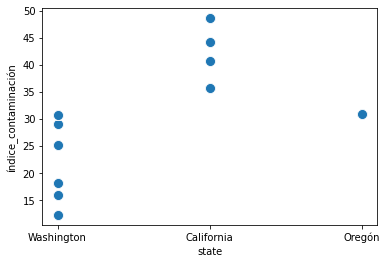

In [53]:
sns.scatterplot(data=df3_limpio, x='state', y='índice_contaminación',
                s = 100); # tamaño de los marcadores

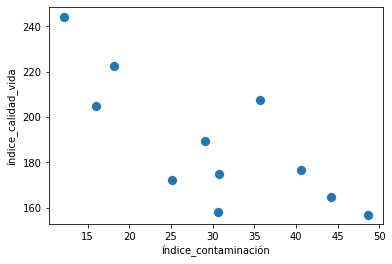

In [54]:
sns.scatterplot(data=df3_limpio, x='índice_contaminación', y='índice_calidad_vida',
                s = 100); # tamaño de los marcadores

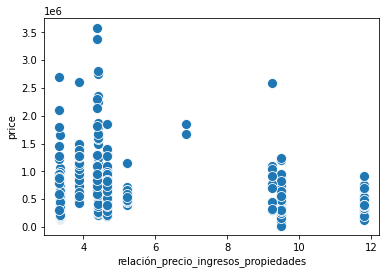

In [55]:
sns.scatterplot(data=df3_limpio, x='relación_precio_ingresos_propiedades', y='price',
                s = 100); # tamaño de los marcadores

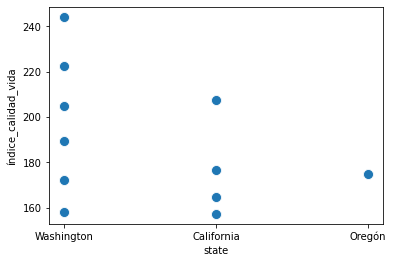

In [56]:
sns.scatterplot(data=df3_limpio, x='state', y='índice_calidad_vida',
                s = 100); # tamaño de los marcadores

In [57]:
sns.scatterplot(data=df3_limpio, x='sanidad', y='índice_contaminación',
                s = 100); # tamaño de los marcadores

ValueError: Could not interpret value `sanidad` for parameter `x`

In [59]:
df3_limpio.groupby(["state", 'city'])["price/m2"].mean()

state       city      
California  Anaheim       4143.416667
            Irvine        5631.888889
            Long Beach    5819.800000
            Pasadena      6771.500000
Oregón      Portland      3154.832117
Washington  Bellevue      5280.111111
            Olympia       2140.655738
            Redmond       4732.705882
            Seattle       5284.610687
            Tacoma        2693.707965
            Vancouver     2364.247423
Name: price/m2, dtype: float64

In [60]:
df3_limpio.groupby(["state", 'city'])["price/m2"].max()

state       city      
California  Anaheim        6382.0
            Irvine         7860.0
            Long Beach    12886.0
            Pasadena       6981.0
Oregón      Portland       8827.0
Washington  Bellevue       9981.0
            Olympia        4851.0
            Redmond        6235.0
            Seattle       15049.0
            Tacoma         6716.0
            Vancouver      6757.0
Name: price/m2, dtype: float64

In [61]:
df3_limpio.groupby(["state", 'city'])["price/m2"].min()

state       city      
California  Anaheim       3296.0
            Irvine        4210.0
            Long Beach    3523.0
            Pasadena      6562.0
Oregón      Portland      1311.0
Washington  Bellevue      3354.0
            Olympia        883.0
            Redmond       3172.0
            Seattle       2083.0
            Tacoma         297.0
            Vancouver     1216.0
Name: price/m2, dtype: float64

In [62]:
df3_limpio.groupby(["state", 'city'])["índice_poder_adqui"].mean().max()

193.53

In [63]:
df3_limpio.groupby(["state", 'city'])["price/m2"].mean()

state       city      
California  Anaheim       4143.416667
            Irvine        5631.888889
            Long Beach    5819.800000
            Pasadena      6771.500000
Oregón      Portland      3154.832117
Washington  Bellevue      5280.111111
            Olympia       2140.655738
            Redmond       4732.705882
            Seattle       5284.610687
            Tacoma        2693.707965
            Vancouver     2364.247423
Name: price/m2, dtype: float64

In [64]:
df3_limpio.groupby(['city'])["price/m2"].max()

city
Anaheim        6382.0
Bellevue       9981.0
Irvine         7860.0
Long Beach    12886.0
Olympia        4851.0
Pasadena       6981.0
Portland       8827.0
Redmond        6235.0
Seattle       15049.0
Tacoma         6716.0
Vancouver      6757.0
Name: price/m2, dtype: float64

In [65]:
df3_limpio.groupby(['city'])["price/m2"].describe()

,count,mean,std,min,25%,50%,75%,max
city,,,,,,,,
Anaheim,12.0,4143.416667,930.418914,3296.0,3637.00,3764.0,4120.25,6382.0
Bellevue,18.0,5280.111111,1744.774312,3354.0,4044.75,4635.0,6068.50,9981.0
Irvine,18.0,5631.888889,1170.170570,4210.0,4797.50,5352.0,5976.75,7860.0
Long Beach,10.0,5819.800000,2778.880542,3523.0,4271.25,4904.5,5787.75,12886.0
Olympia,122.0,2140.655738,874.637576,883.0,1296.50,2190.5,2654.00,4851.0
Pasadena,2.0,6771.500000,296.277741,6562.0,6666.75,6771.5,6876.25,6981.0
Portland,137.0,3154.832117,1174.826887,1311.0,2363.00,2918.0,3563.00,8827.0
Redmond,17.0,4732.705882,813.000059,3172.0,4438.00,4845.0,5233.00,6235.0
Seattle,131.0,5284.610687,2088.454153,2083.0,3899.00,5025.0,6132.00,15049.0


In [66]:
df3_limpio.groupby(["state", 'city'])["price/m2"].min()

state       city      
California  Anaheim       3296.0
            Irvine        4210.0
            Long Beach    3523.0
            Pasadena      6562.0
Oregón      Portland      1311.0
Washington  Bellevue      3354.0
            Olympia        883.0
            Redmond       3172.0
            Seattle       2083.0
            Tacoma         297.0
            Vancouver     1216.0
Name: price/m2, dtype: float64

In [67]:
df3_limpio.groupby(["state", 'city'])["price"].min()

state       city      
California  Anaheim        400000
            Irvine         599999
            Long Beach     310000
            Pasadena      1680000
Oregón      Portland       199900
Washington  Bellevue       299950
            Olympia        146999
            Redmond        425000
            Seattle        224950
            Tacoma          27900
            Vancouver      135000
Name: price, dtype: int64

In [68]:
df3_limpio.groupby(["state", 'city'])["price"].mean().round()

state       city      
California  Anaheim        666788.0
            Irvine        1390552.0
            Long Beach     867099.0
            Pasadena      1765000.0
Oregón      Portland       565327.0
Washington  Bellevue      1118025.0
            Olympia        390706.0
            Redmond       1081514.0
            Seattle        840242.0
            Tacoma         399957.0
            Vancouver      396967.0
Name: price, dtype: float64

In [69]:
df3_limpio.groupby(["state"])["price"].min()

state
California    310000
Oregón        199900
Washington     27900
Name: price, dtype: int64

In [70]:
df3_limpio.groupby(["state"])["price"].max().round(0)

state
California    3580000
Oregón        1850000
Washington    2800000
Name: price, dtype: int64

In [71]:
df3_limpio.groupby(["state"])["price"].mean().round(0)

state
California    1076962.0
Oregón         565327.0
Washington     562147.0
Name: price, dtype: float64

In [72]:
df5 = pd.DataFrame(df3_limpio.groupby(["state", 'city','postal_code'])["price/m2"].mean())
df5

price/m2
state      city      postal_code             
California Anaheim   92801        3562.500000
                     92802        3687.500000
                     92804        5255.000000
                     92805        4196.000000
                     92806        4095.000000
...                                       ...
Washington Vancouver 98682        2287.896552
                     98683        2260.600000
                     98684        2118.272727
                     98685        2229.666667
                     98686        2638.750000

[111 rows x 1 columns]

In [73]:
df4 = pd.DataFrame(df3_limpio.groupby(["state", 'city','postal_code'])["price/m2"].max())
df4

price/m2
state      city      postal_code          
California Anaheim   92801          3812.0
                     92802          3716.0
                     92804          6382.0
                     92805          4196.0
                     92806          4095.0
...                                    ...
Washington Vancouver 98682          3050.0
                     98683          2431.0
                     98684          2851.0
                     98685          2387.0
                     98686          6757.0

[111 rows x 1 columns]

In [74]:
df4.shape

(111, 1)

In [75]:
df3_limpio.groupby(["state", 'city'])["price/m2"].min()

state       city      
California  Anaheim       3296.0
            Irvine        4210.0
            Long Beach    3523.0
            Pasadena      6562.0
Oregón      Portland      1311.0
Washington  Bellevue      3354.0
            Olympia        883.0
            Redmond       3172.0
            Seattle       2083.0
            Tacoma         297.0
            Vancouver     1216.0
Name: price/m2, dtype: float64